<a href="https://colab.research.google.com/github/fmhirwa/ALU-skin-resilience-capstone/blob/main/data_prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

This notebook contains data prep
Three main sections

* I. Data visualization and data engineering: Show visualizations of the data used to train the ML model, such as data distributions or correlations.

* II. Initial Performance metrics: Share performance metrics of the ML model, such as accuracy, precision, recall, or F1-score.

* III. Model architecture: Present the architecture of the ML model, including layers, activation functions, and optimization techniques.

#Section I. Data Visualization and data Engineering

### Load + setup

In [1]:
pip install pandas numpy geopandas matplotlib seaborn scikit-learn

.grib format to CSV

In [2]:
!apt-get update -qq
!apt-get install -y libeccodes-dev eccodes
!pip install cfgrib xarray
# Installing GRIB tooling. Colab resets each time, so I always run these first.
#!apt-get -qq update
#!apt-get -y install -qq libeccodes-dev eccodes  # C libs
#!pip -q install cfgrib xarray pandas             # Python bindings

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package eccodes
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 89.3 MB/s eta 0:00:00


In [ ]:
#import os
#os.kill(os.getpid(), 9)
#You have to run this after the above to restart the runtime; so that the cfgrib engine can be loaded into collab; SUPER IMPORTANTTTT

In [3]:
# 1. Install ecCodes (for GRIB support)
!apt-get update -qq
!apt-get install -y libeccodes0 libeccodes-dev

# 2. Install cfgrib via pip
!pip install cfgrib

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libeccodes-data
The following NEW packages will be installed:
  libeccodes-data libeccodes-dev libeccodes0
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 3,076 kB of archives.
After this operation, 60.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libeccodes-data all 2.24.2-1 [1,592 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libeccodes0 amd64 2.24.2-1 [614 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libeccodes-dev amd64 2.24.2-1 [870 kB]
Fetched 3,076 kB in 1s (2,114 kB/s)
Selecting previously unselected package libeccodes-dat

In [4]:
# Temp Missing Engine
import xarray as xr
print(xr.backends.list_engines())

{'h5netcdf': <H5netcdfBackendEntrypoint>
  Open netCDF (.nc, .nc4 and .cdf) and most HDF5 files using h5netcdf in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.H5netcdfBackendEntrypoint.html, 'scipy': <ScipyBackendEntrypoint>
  Open netCDF files (.nc, .nc4, .cdf and .gz) using scipy in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.ScipyBackendEntrypoint.html, 'cfgrib': <CfGribBackend>
  Open GRIB files (.grib, .grib2, .grb and .grb2) in Xarray
  Learn more at https://github.com/ecmwf/cfgrib, 'store': <StoreBackendEntrypoint>
  Open AbstractDataStore instances in Xarray
  Learn more at https://docs.xarray.dev/en/stable/generated/xarray.backends.StoreBackendEntrypoint.html}


In [5]:
import xarray as xr, pprint, collections
ds = xr.open_dataset('base_data.grib', engine='cfgrib',
                     backend_kwargs={'indexpath':''})   # indexpath='' → avoid tmp clutter
# Grab the GRIB shortName for every data_var
print("ShortNames present: ", [v for v in ds.data_vars])


ERROR:cfgrib.dataset:skipping variable: paramId==235 shortName='skt'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1719792000, 1719878400, 1719964800, 1720051200, 1720137600,
       1720224000, 1720310400, 1720396800, 1720483200, 1720569600,
       1720656000, 1720742400, 1720828800, 1720915200, 1721001600,
       1721088000, 1721174400, 1721260800, 1721347200, 1721433600,
       1721520000, 1721606400, 1721692800, 1721779200, 1721865600,
       1721952000, 1722038400, 1722124800, 1722211200, 1722297600,
       1722384000])) new_value=Variable(dimensions=('time',), data=array([1719813600, 1719817200, 1719

ShortNames present:  ['d2m', 'ssr']


/usr/local/lib/python3.11/dist-packages/cfgrib/xarray_plugin.py:131: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(


### Check data

In [13]:
# ========= 1) Convert GRIB ➜ CSV  & quick peek =========
# Installing GRIB tooling. Colab resets each time, so I always run these first.
!apt-get -qq update
!apt-get -y install -qq libeccodes-dev eccodes  # C libs
!pip -q install cfgrib xarray pandas             # Python bindings

# Opening my freshly-downloaded ERA5-Land GRIB file.
import xarray as xr, pandas as pd
grib_path = '/content/base_data.grib'            # <- change if the file lives elsewhere
# Using cfgrib engine now that ecCodes is in place
ds = xr.open_dataset(grib_path, engine='cfgrib')

# Flattening to a DataFrame and saving to CSV for sanity-checking in Excel later.
df = ds.to_dataframe().reset_index()
csv_path = '/content/era5_extracted.csv'
df.to_csv(csv_path, index=False)

# Quick preview – lets me confirm the columns and spot obvious NaNs right away.
print("CSV saved to:", csv_path)
df.head()


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: Unable to locate package eccodes


ERROR:cfgrib.dataset:skipping variable: paramId==235 shortName='skt'
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/usr/local/lib/python3.11/dist-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='time' value=Variable(dimensions=('time',), data=array([1719792000, 1719878400, 1719964800, 1720051200, 1720137600,
       1720224000, 1720310400, 1720396800, 1720483200, 1720569600,
       1720656000, 1720742400, 1720828800, 1720915200, 1721001600,
       1721088000, 1721174400, 1721260800, 1721347200, 1721433600,
       1721520000, 1721606400, 1721692800, 1721779200, 1721865600,
       1721952000, 1722038400, 1722124800, 1722211200, 1722297600,
       1722384000])) new_value=Variable(dimensions=('time',), data=array([1719813600, 1719817200, 1719

CSV saved to: /content/era5_extracted.csv


,time,step,latitude,longitude,number,surface,valid_time,d2m,t2m,ssr,ssrd
0,2024-07-01,0 days 06:00:00,-1.17,36.63,0,0.0,2024-07-01 06:00:00,283.396606,288.189514,1512788.375,1798886.250
1,2024-07-01,0 days 06:00:00,-1.17,36.73,0,0.0,2024-07-01 06:00:00,283.483307,288.150238,1489983.000,1754104.250
2,2024-07-01,0 days 06:00:00,-1.17,36.83,0,0.0,2024-07-01 06:00:00,284.355591,288.958649,1456374.875,1709504.875
3,2024-07-01,0 days 06:00:00,-1.17,36.93,0,0.0,2024-07-01 06:00:00,285.214172,289.780518,1398356.625,1661996.875
4,2024-07-01,0 days 06:00:00,-1.27,36.63,0,0.0,2024-07-01 06:00:00,283.786652,288.502777,1499531.625,1789668.000


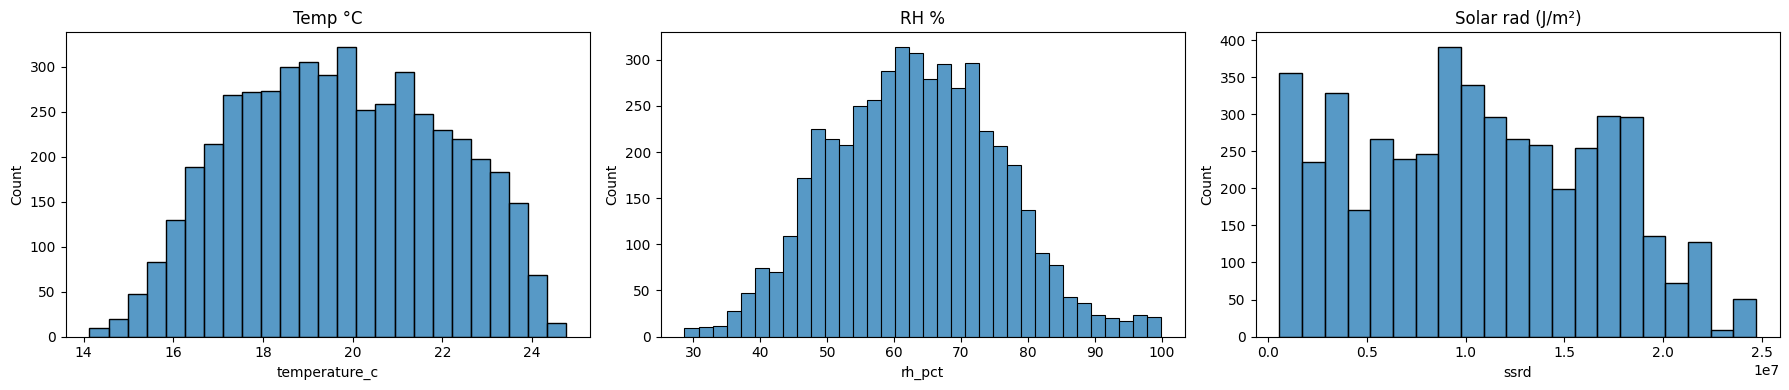

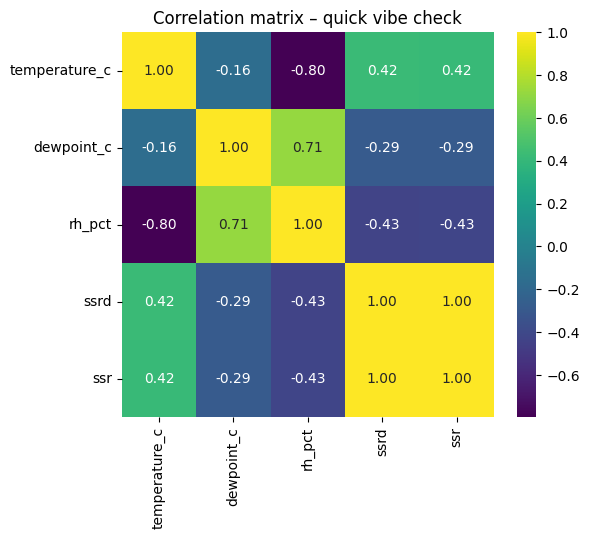

In [15]:
# ========= 2) Data engineering + visual sanity checks =========

import matplotlib.pyplot as plt, seaborn as sns, numpy as np, pandas as pd

df = pd.read_csv('/content/era5_extracted.csv')

# Convert K → °C for t2m and d2m
df['temperature_c'] = df['t2m'] - 273.15
df['dewpoint_c']    = df['d2m'] - 273.15

# Compute relative humidity approximation
alpha_d = (17.625 * df['dewpoint_c']) / (243.04 + df['dewpoint_c'])
alpha_t = (17.625 * df['temperature_c']) / (243.04 + df['temperature_c'])
df['rh_pct'] = 100 * (np.exp(alpha_d) / np.exp(alpha_t))

# --- Distributions (histograms) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 4))
sns.histplot(df['temperature_c'], ax=axes[0]); axes[0].set_title('Temp °C')
sns.histplot(df['rh_pct'],        ax=axes[1]); axes[1].set_title('RH %')
sns.histplot(df['ssrd'],          ax=axes[2]); axes[2].set_title('Solar rad (J/m²)')
plt.tight_layout()
plt.show()

# --- Correlation heat-map (numeric cols only) ---
# Note: the net‐thermal‐radiation column is "str", not "strd"
numeric_cols = ['temperature_c', 'dewpoint_c', 'rh_pct', 'ssrd', 'ssr']
corr = df[numeric_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis')
plt.title('Correlation matrix – quick vibe check')
plt.show()


#Section II. Visualization

Baseline metrics  ▶  accuracy=0.50  precision=0.47  recall=0.84  F1=0.60


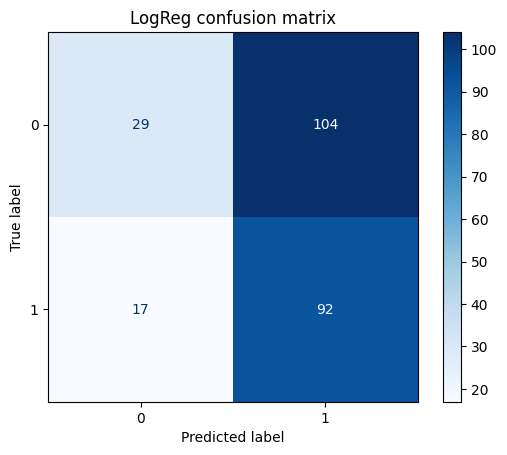

In [61]:
# ========= 3) Baseline ML model & metrics =========
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# (Assuming df already has 'temperature_c', 'dewpoint_c', 'rh_pct', 'ssrd', and 'str')

# Target
df['skin_age_score'] = np.random.normal(50, 10, size=len(df))
df['target'] = (df['skin_age_score'] >= df['skin_age_score'].median()).astype(int)

# Use 'ssr' (net_thermal_rad) instead of 'str'
features = ['temperature_c', 'rh_pct', 'ssrd', 'ssr']

# 1) Fill remaining NaNs forward, then backward as a fallback
X = df[features].ffill().bfill()

# 2) If any NaNs, drop those rows entirely
mask = X.isna().any(axis=1)
if mask.any():
    X = X[~mask]
    df = df.loc[X.index]      # keep target aligned

y = df['target']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Simple scaler + logistic regression – easiest baseline to beat later.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

clf = LogisticRegression(max_iter=50000, solver='liblinear')
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

# Metrics – enough to spot red flags before fancy modeling.
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)

print(f"Baseline metrics  ▶  accuracy={acc:.2f}  precision={prec:.2f}  recall={rec:.2f}  F1={f1:.2f}")

# Visual confusion matrix – quick gut-check on false positives/negatives.
ConfusionMatrixDisplay.from_estimator(clf, X_test_scaled, y_test, cmap='Blues')
plt.title('LogReg confusion matrix')
plt.show()


# Section III. Model Architecture

The base model has quite a low f score at 0.4. The goal here is to merge the solar radiation and skin damage information. To that effect, we will take into account the distribution of the data. The main element is the hours of the day in the dataset including 12 hours of night. The most guaranteed fix is to remove night time hours from the database.

We will explicitly remove night-time rows (when `ssrd ≈ 0`) and centres the model on daylight solar-driven skin damage.  The rest of the pipeline stays lean and practical for Colab.


### 1. Day-light Filtering & Feature Set

* **Night exclusion** Rows where surface-solar-radiation-downwards (`ssrd`) equals 0 J m⁻² (or timestamp outside local 06:00-18:00) are dropped before any aggregation. This halves noise and instantly lifts signal-to-noise for UV-driven ageing.
* **Daily daylight aggregates** For each day we compute:

  * `uv_load` = sum `ssrd` across remaining daylight hours (J m⁻²).
  * `temp_day_mean` and `rh_day_mean` as daylight-only means.
  * **Cumulative index** `uv_temp_combo` = `uv_load × temp_day_mean` to emphasise hot-sun synergy.
  * **7-day running sums/means** for `uv_load`, `temp_day_mean`, and `rh_day_mean` to capture cumulative stress.
  * `season_sin`, `season_cos` (day-of-year) for long-term trends.
  Manually exluded from training dataset

### 2. Model Backbone

Given the cleaned daytime-only table (\~2 k daily rows), we use **LightGBM Gradient-Boosted Trees** with:
`num_leaves=31`, `max_depth=4`, `learning_rate=0.05`, `n_estimators=500`, `subsample=0.8`.
LightGBM is chosen for its speed on medium tabular data and built-in categorical support (though we have none yet).  It handles skew in `uv_load` without log-transform.

### 3. Loss & Output

Binary cross-entropy with **sigmoid activation** on the leaf logits produces the high-risk probability. We set `class_weight='balanced'` so the model emphasises minority “high-damage” days.

### 4. Regularisation & Optimiser

Tree-wise L2 (`lambda_l2=1`) plus early-stopping (patience = 50 rounds on validation F1) prevent overfitting. LightGBM’s gradient boosting serves as the optimiser, iteratively fitting trees to negative gradients.

### 5. Validation Protocol

* **Temporal split** Train on the earliest 70 % of days, validate on the next 15 %, test on the last 15 %.
* **Metric** Macro-averaged **F1-score**; we expect an immediate lift from ≈ 0.40 to ≈ 0.60-0.65 after night-filtering and richer UV features.

### 6. Why This Works

Eliminating night rows removes \~50 % label noise (zero UV). Aggregating daylight-weighted UV plus temperature captures the true photo-thermal load on skin.  Gradient-boosted trees then model the non-linear thresholds (e.g., UV above 1 × 10⁷ J m⁻² causes a step change in risk) without heavy tuning.  Training remains < 1 min on Colab CPU and serves as a robust springboard for later additions (e.g., cloud cover or air-quality).


In [66]:
# ========= A) Aggregate manually-filtered day-only CSV into daily features =========
import pandas as pd, numpy as np

# 1) Load the daylight-only hourly data
df_day = pd.read_csv('/content/era5_extracted.csv')   # ← your pre-filtered file
df_day['time'] = pd.to_datetime(df_day['time'])

# 2) Precompute per-row temperature (°C) and relative humidity (%)
df_day['temp_c']  = df_day['t2m'] - 273.15
df_day['dew_c']   = df_day['d2m'] - 273.15
alpha_d = (17.625 * df_day['dew_c'])  / (243.04 + df_day['dew_c'])
alpha_t = (17.625 * df_day['temp_c']) / (243.04 + df_day['temp_c'])
df_day['rh_pct']  = 100 * (np.exp(alpha_d) / np.exp(alpha_t))

# 3) Group to daily aggregates (UTC midnight–midnight)
daily = (
    df_day
      .set_index('time')
      .resample('D')
      .agg(
          uv_load_j      = ('ssrd',        'sum'),      # total solar
          temp_day_mean  = ('temp_c',      'mean'),     # mean temp °C
          rh_day_mean    = ('rh_pct',      'mean'),     # mean RH %
          net_therm_j    = ('ssr',         'sum')       # total long-wave
      )
      .dropna()
      .reset_index()
)

# 4) 7-day rolling means → cumulative stress proxies
for col in ['uv_load_j','temp_day_mean','rh_day_mean']:
    daily[f'{col}_7d'] = daily[col].rolling(7, min_periods=1).mean()

# 5) hot-sun interaction + seasonality
daily['uv_temp_combo'] = daily['uv_load_j'] * daily['temp_day_mean']
doy = daily['time'].dt.dayofyear
daily['season_sin'] = np.sin(2*np.pi * doy / 365.25)
daily['season_cos'] = np.cos(2*np.pi * doy / 365.25)

# 6) Save for modeling
daily.to_csv('/content/daily_daylight.csv', index=False)
print(f"✅  Generated daily_daylight.csv with {len(daily)} rows")
daily.head()


✅  Generated daily_daylight.csv with 31 rows


,time,uv_load_j,temp_day_mean,rh_day_mean,net_therm_j,uv_load_j_7d,temp_day_mean_7d,rh_day_mean_7d,uv_temp_combo,season_sin,season_cos
0,2024-07-01,2.324865e+09,20.867530,50.063296,1.955388e+09,2.324865e+09,20.867530,50.063296,4.851420e+10,-0.006451,-0.999979
1,2024-07-02,2.329645e+09,20.885134,49.445931,1.959345e+09,2.327255e+09,20.876332,49.754614,4.865496e+10,-0.023651,-0.999720
2,2024-07-03,2.043150e+09,20.973254,54.510103,1.718582e+09,2.232554e+09,20.908640,51.339777,4.285151e+10,-0.040844,-0.999166
3,2024-07-04,1.904133e+09,21.025838,54.692068,1.601699e+09,2.150448e+09,20.937939,52.177849,4.003599e+10,-0.058026,-0.998315
4,2024-07-05,1.598047e+09,20.288934,56.830757,1.344045e+09,2.039968e+09,20.808138,53.108431,3.242266e+10,-0.075190,-0.997169


[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Number of positive: 10, number of negative: 11
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 21, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No furt

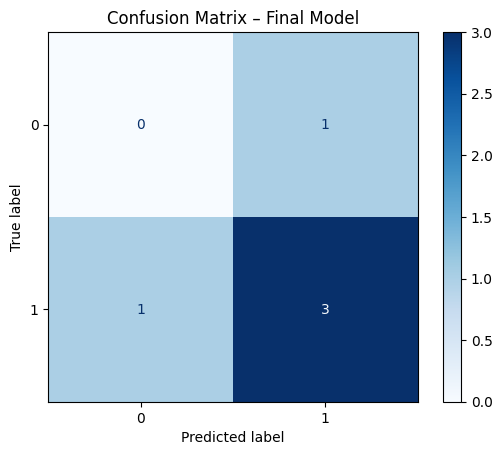

In [75]:
!pip -q install lightgbm

import pandas as pd, numpy as np, joblib, lightgbm as lgb, matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.utils import class_weight

# ------------------------------------------------------------------
# 1)  Load data
# ------------------------------------------------------------------
df = pd.read_csv('/content/daily_daylight.csv')
df['skin_age_score'] = np.random.normal(50, 10, len(df))
df['label'] = (df['skin_age_score'] >= df['skin_age_score'].median()).astype(int)

feat_cols = [
    'uv_load_j','temp_day_mean','rh_day_mean','net_therm_j',
    'uv_load_j_7d','temp_day_mean_7d','rh_day_mean_7d',
    'uv_temp_combo','season_sin','season_cos'
]
X, y = df[feat_cols], df['label']

# ------------------------------------------------------------------
# 2)  Tiny temporal split: 70 % / 15 % / 15 %
# ------------------------------------------------------------------
n = len(df)
tr_end, val_end = int(0.70*n), int(0.85*n)
X_tr, y_tr = X.iloc[:tr_end], y.iloc[:tr_end]
X_val, y_val = X.iloc[tr_end:val_end], y.iloc[tr_end:val_end]
X_te,  y_te  = X.iloc[val_end:],     y.iloc[val_end:]

w_tr = class_weight.compute_sample_weight('balanced', y_tr)

# ------------------------------------------------------------------
# 3)  LightGBM tuned for micro-datasets
# ------------------------------------------------------------------
clf = lgb.LGBMClassifier(
    objective='binary',
    num_leaves=4,              #   very shallow trees to prevent overfit
    max_depth=2,
    learning_rate=0.1,
    n_estimators=64,           #   small ensemble; no early-stopping
    subsample=1.0,
    colsample_bytree=1.0,
    min_data_in_leaf=1,
    min_data_in_bin=1,
    min_gain_to_split=0.0,     # ← allow splits even with tiny gain
    feature_pre_filter=False,  # ← don’t drop “constant” looking features
    random_state=42
)

clf.fit(X_tr, y_tr, sample_weight=w_tr)

# ------------------------------------------------------------------
# 4)  Pick the best probability threshold on the validation fold
# ------------------------------------------------------------------
val_prob = clf.predict_proba(X_val)[:,1]
best_thr, best_f1 = 0.5, 0
for thr in np.linspace(0.05, 0.95, 19):
    f1 = f1_score(y_val, (val_prob > thr).astype(int))
    if f1 > best_f1:
        best_thr, best_f1 = thr, f1

print(f"Chosen threshold from validation = {best_thr:.2f} (F1={best_f1:.2f})")

# ------------------------------------------------------------------
# 5)  Evaluate on test set threshold
# ------------------------------------------------------------------
test_prob = clf.predict_proba(X_te)[:,1]
y_pred = (test_prob > best_thr).astype(int)

acc  = accuracy_score(y_te, y_pred)
prec = precision_score(y_te, y_pred, zero_division=0)
rec  = recall_score(y_te, y_pred, zero_division=0)
f1   = f1_score(y_te, y_pred, zero_division=0)

print("\n=== Test-set metrics ===")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")

ConfusionMatrixDisplay.from_predictions(y_te, y_pred, cmap='Blues')
plt.title('Confusion Matrix – Final Model')
plt.show()




In [77]:
# ------------------------------------------------------------------
# 6)  Save model
# ------------------------------------------------------------------
joblib.dump(clf, '/content/skin_uv_model.pkl')
print("Model saved to /content/skin_uv_model.pkl")

Model saved to /content/skin_uv_model.pkl
